<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">

# snnTorch - Neuronal Dynamics with ``snntorch``
## Tutorial 2
### By Jason K. Eshraghian

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_2_neurons.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction
In this tutorial, you will learn how to:
* Use snnTorch to implement leaky integrate-and-fire neuron models: 
  * Stein's neuron model
  * A recursive version of the 0$^{th}$ Order Spike Response Model
* Plot the output behavior of the neurons
* Interpret the computational graph of a spiking neuron
* Automatically initialize the hidden states of the neurons [keep in tute, but delete explanation]?
* Implement a feedforward spiking neural network

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install snntorch

# 1. The Spectrum of Neuron Models
A large variety of neuron models are out there, ranging from biophysically accurate models (i.e., the Hodgkin-Huxley models) to the grossly simplified artificial neuron that you may already be familiar with in your studies of deep learning. 

While biophysical models use experimental evidence to prove they are tightly linked to real neurons, their mathematical complexity makes them difficult to use. In fact, it is quite challenging to do anything useful beyond forecasting how a real neuron may respond to a stimulus. We expect this to change as neuroscientists continue to develop more rigorous theories of how neurons contribute to higher-order behaviors in the brain.

On the other end of the spectrum is the artificial neuron. The inputs are multiplied by their corresponding weights, and passed through an activation function. If the artificial neuron wasn't so useful, it would be an insult to the complexity of a biophysical neuron. This simplification has enabled deep learning researchers to perform incredible feats in computer vision, natural language processing, and many other domains commonly associated with machine learning.

Somewhere in the middle of the divide lies the leaky integrate-and-fire (LIF) neuron model. It takes the sum of weighted inputs, much like the artificial neuron. But rather than passing it directly to an activation function, it will integrate the input over time with a temporal decay, or 'leakage'. If the integrated value exceeds a threshold, then the LIF neuron will emit a voltage spike, loosely similar to the Hodgkin-Huxley (HH) models. Thus, the LIF neuron sits in the sweet spot between biological plausibility and practicality. 

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">
</center>

Researchers might spend their entire lives dedicated to developing neuron models. Some of these models are straightforward extensions of the HH and LIF models, while other models find completely different applications, such as in neuropharmocology.

The different versions of the LIF model each have their own temporal dynamics and different use-cases. snnTorch currently supports two types of LIF neurons:
* Stein's neuron model: ``snntorch.Stein``
* A recursive version of the 0$^{th}$ Order Spike Response Model: ``snntorch.SRM0``

<!-- In general, the most obvious difference is that the SRM0 model incorporates a delay between the input and output. When an input spike arrives at an SRM0 neuron, the membrane potential will increase over a finite time. If an output spike were to be triggered, it would experience a delay with respect to the input. On the other hand, Stein's model allows for an instantaneous rise of membrane potential. We'll dig into where these might be useful shortly. -->

Let's learn how they work by actually using them.


# 2. Stein's LIF Neuron Model

## 2.1 A Hands-on Approach
First, import the libraries needed to run Stein's neuron model before we get into describing what's going on under the hood. 

In [2]:
import snntorch as snn
import torch
import torch.nn as nn

Stein's neuron model takes one input and contains two internal states:
* *Input:* current stimulus
* *Hidden:* Membrane potential
* *Hidden:* Synaptic current flow

In absence of any input current stimulus, the membrane potential and synaptic current will simply decay to nothing over time. 

The decay rate of synaptic current flow is $\alpha$. 
The decay rate of membrane potential is $\beta$.

At the very minimum, we need need to define $\alpha =$ `alpha` and $\beta=$ `beta` to create an instantiation of Stein's neuron model. As long as they are between 0 and 1, the membrane and synaptic current are guaranteed to decay.


In [6]:
# Arbitrarily choose alpha and beta; must be between 0 and 1
alpha = 0.6
beta = 0.8

# Number of time steps to simulate
num_steps = 50

Instantiating a Stein neuron only requires the following line of code:

In [7]:
# leaky integrate and fire neuron
lif1 = snn.Stein(alpha=alpha, beta=beta)

To use this neuron, the input and the two hidden states must be initialized.

Additionally, the neuron needs a place to pass its output spikes. So let's initialize the following for the first time step:

* $I_{\rm syn}[t=0] = 0.15;$ *synaptic current:* `syn`
* $U[t=0] = 0.6;$ *membrane potential:* `mem`
* $S_{\rm in}[t]=0;$  *input spikes:* `spk_in`
> We want to find out what happens to $I_{\rm syn}$ and $U$ when there is no input. So a 1-D tensor of length `num_steps` with an entry of `0` at each time step is applied as input.

* $S_{\rm out}[t=0] = 0;$ *output spike:* `spk_out`

These all need to be of type `torch.Tensor`.

In [8]:
# Initialize hidden states, input, and output
syn = torch.ones(1) * 0.15  # synaptic current of 0.15 at t=0
mem = torch.ones(1) * 0.6  # membrane potential of 0.6 at t=0
spk_in = torch.zeros(num_steps)  # input is 0 for all t 
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes

We'd like to understand how the hidden states, `mem` and `syn` evolve over time. The lists `mem_rec` and `syn_rec` are initialized to record these values at every time step. We can do the same for `spk_out` too.

In [9]:
# Initialize a place to store recordings of current, potential, and spikes
syn_rec = [syn]
mem_rec = [mem]
spk_rec = [spk_out]

Now it's time to run a simulation! Here's what's going to happen:
* Each element of `spk_in` is sequentially passed into Stein's neuron model, `lif1`. Recall these are all `0`. This is done using a for-loop.
* The present time value of both hidden states `syn` and `mem` must also be passed into the neuron.
* `lif1` will return three things:
  * $S_{\rm out}[t+1];$ *output spike at t+1:* `spk_out`
  * $I_{\rm syn}[t+1];$ *synaptic current at t+1:* `syn`
  * $U[t+1];$ *membrane potential at t+1:* `mem`

We'll use the `append` command to store `spk`, `syn`, and `mem` into the recording lists. 

In [10]:
for step in range(num_steps):
  spk_out, syn, mem = lif1(spk_in[step], syn, mem)

  # Store recordings of output and hidden states
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

Well that was simple. 

Let's take a look at how the membrane potential and synaptic current evolved.

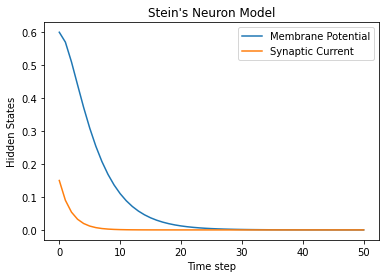

In [11]:
import matplotlib.pyplot as plt

plt.title("Stein's Neuron Model")
plt.plot(mem_rec, label="Membrane Potential")
plt.plot(syn_rec, label="Synaptic Current")
plt.xlabel("Time step")
plt.ylabel("Hidden States")
plt.legend()
plt.show()

So we've convinced ourselves that the membrane and synapse will decay over time. 

Let's take a look at what the output spike recording looks like:

In [14]:
print(spk_rec)

[tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.]), tensor([0.])]


Just a bunch of zeros, huh? Not that exciting. 

The thing is, the membrane potential $U$ must increase to a high enough value, i.e. its threshold $U_{\rm thr}$, before the neuron can generate its own spikes. 

We need the input $S_{\rm in}$ to be something other than 0 in order to excite the neuron.

### 2.1.1 Generating Input Spikes
Let's use some of the skills we learnt in [Tutorial 1](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_1_spikegen.ipynb), and use the `snntorch.spikegen` module to create some randomly generated input spikes for Stein's neuron model.

In [15]:
from snntorch import spikegen 

# Create a 1-D random spike train. Each element has a probability of 10% of firing.
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.10)

It's pretty easy to see how many spikes have been generated by doing a quick count, and also a raster plot using the `snntorch.spikeplot`.

There are 5.0 total spikes in spike_rand out of 50 time steps.


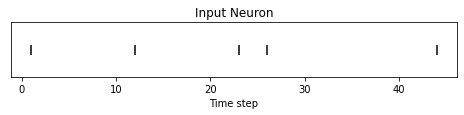

In [16]:
# Tell me the number of spikes
print(f"There are {sum(spk_in)} total spikes in spike_rand out of {len(spk_in)} time steps.")

# Now show me the spikes
from snntorch import spikeplot as splt

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

### 2.1.2 Passing input spikes to the neuron
These inputs spikes are now fed into the neuron. Each spike from `spk_in` has a value of `1`, while an absence of a spike is `0`. In an actual neural network, the input spikes would usually be weighted between -1 and 1 by the synapses that connect neurons together. So let's first reduce the strength of each spike arbitrarily to 40% (i.e., 1 $\rightarrow$ 0.4).

Don't forget to re-initialize the hidden and output variables as this is a new simulation run.

In [17]:
# Reduce input spike strength
spk_in = spk_in * 0.4

# Refresh all our hidden and output variables
syn = torch.ones(1) * 0.15  # synaptic current of 0.15 at t=0
mem = torch.ones(1) * 0.6  # membrane potential of 0.6 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to dump its output spikes

# Create a trace of the variables of interest
syn_rec = [syn]
mem_rec = [mem]
spk_rec = [spk_out]

# Run the simulation
for step in range(num_steps):
  spk_out, syn, mem = lif1(spk_in[step], syn, mem)

  # Store recordings of output and hidden states
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

Now to plot the results of our simulation.

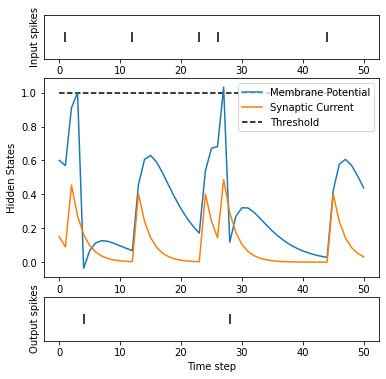

In [18]:
from matplotlib import gridspec

fig = plt.figure(facecolor="w", figsize=(6, 6))
spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[0.4, 1.8, 0.4])

# Plot input spikes
ax0 = fig.add_subplot(spec[0])
splt.raster(spk_in.reshape(num_steps, -1), ax0, s=100, c="black", marker="|")
plt.ylabel("Input spikes")
plt.yticks([]) 

# Plot hidden spikes
ax1 = fig.add_subplot(spec[1], sharex = ax0)
plt.plot(mem_rec, label="Membrane Potential")
plt.plot(syn_rec, label="Synaptic Current")
plt.hlines(lif1.threshold, 0, num_steps, colors='black', linestyles='dashed', label='Threshold')  # Plots a threshold bar
plt.ylabel("Hidden States")
# plt.xticks([]) 
plt.legend()

# Plot output spikes generated by neuron
ax2 = fig.add_subplot(spec[2], sharex = ax1)
splt.raster(torch.tensor(spk_rec[0:50]).reshape(num_steps, -1), ax2, s=100, c="black", marker="|")
plt.yticks([]) 
plt.xlabel("Time step")
plt.ylabel("Output spikes")
plt.xticks()

plt.show()

> Note: if no output spikes were generated, this is most likely because the input had insufficient spiking to enable the membrane to reach the threshold. You might want to rerun everything from the following code block:

> `spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.10)`

> Increasing the value from `0.10` should increase your input firing frequency.

Here are a few observations that will give you intuition behind how this leaky integrate-and-fire neuron behaves:

1.   **Leaky**: When there is no input spike, the membrane and synaptic current both decay. That's what is meant by the **leaky** in **leaky integrate-and-fire**. 
2.   **Integrate**: Every time an input spike occurs, note how the neuron's synaptic current increases by the same amount (if there are larger jumps, this is likely due to multiple input spikes occurring very closely to each other). Here, our spikes have been scaled by a factor of 0.4, so the increase of current is also 0.4. The synaptic current is added to the membrane potential at every time step, which causes larger jumps in membrane potential. That is to say, the current **integrates** the input spikes, and the membrane **integrates** the curent.
3.   **Fire**: When the membrane potential reaches the threshold (set to 1.0 by default), an output spike is emitted. That's what is meant by **fire**. 


### 2.1.3 The Firing Threshold
What might we expect if the threshold was decreased? 

This would make it easier for the membrane to reach the lower threshold. Therefore, more output spikes should be induced. Let's verify our theory by initializing another Stein neuron model, but this time explicitly passing `threshold=0.5` as an argument to override the default threshold:

In [39]:
# leaky integrate and fire neuron
lif2 = snn.Stein(alpha=alpha, beta=beta, threshold=0.5)

`alpha` and `beta` are both the same as before. The only thing that has changed is the threshold.

Now let's reinitialize our state variables, our outputs, and pass the exact same input spikes back into the neuron:

In [40]:
# Refresh all our hidden and output variables
syn = torch.ones(1) * 0.15  # synaptic current of 0.15 at t=0
mem = torch.ones(1) * 0.6  # membrane potential of 0.6 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to dump its output spikes

syn_rec = [syn]
mem_rec = [mem]
spk_rec = [spk_out]

for step in range(num_steps):
  spk_out, syn, mem = lif2(spk_in[step], syn, mem)

  # Store recordings of output and hidden states
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

Plotting the above results:

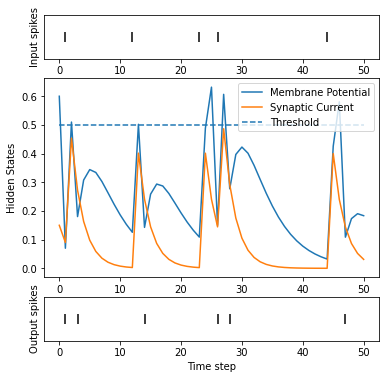

In [41]:
fig = plt.figure(facecolor="w", figsize=(6, 6))
spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[0.4, 1.8, 0.4])

# Plot input spikes
ax0 = fig.add_subplot(spec[0])
splt.raster(spk_in.reshape(num_steps, -1), ax0, s=100, c="black", marker="|")
plt.ylabel("Input spikes")
plt.yticks([]) 

# Plot hidden states
ax1 = fig.add_subplot(spec[1], sharex = ax0)
plt.plot(mem_rec, label="Membrane Potential")
plt.plot(syn_rec, label="Synaptic Current")
plt.hlines(lif2.threshold, 0, num_steps, colors=None, linestyles='dashed', label='Threshold')  # Plots a threshold bar
plt.ylabel("Hidden States")
# plt.xticks([]) 
plt.legend()

# Plot output spikes generated by neuron
ax2 = fig.add_subplot(spec[2], sharex = ax1)
splt.raster(torch.tensor(spk_rec[0:50]).reshape(num_steps, -1), ax2, s=100, c="black", marker="|")
plt.yticks([]) 
plt.xlabel("Time step")
plt.ylabel("Output spikes")
plt.xticks()

plt.show()

Looks like our theory was right! Dropping our threshold generates more spiking.

### 2.1.4 The Reset Mechanism 
One more thing worth noting is how the membrane potential experiences a sharp drop every time the neuron emits an output spike. This sharp drops promotes a reduction of spike generation, which supplements part of the theory on how brains are so power efficient. Biologically, this is known as the 'refractory period' where the the neuron's firing ability is suppressed. Here, we use a reset mechanism to crudely model the refractory period. 

There are two ways to implement the reset mechanism:

1.  *reset by subtraction* (default) $-$ subtract the threshold from the membrane potential each time a spike is generated;
2.   *reset to zero* $-$ force the membrane potential to zero each time a spike is generated.

Let's instantiate another neuron model to demonstrate how to alternate between reset mechanisms. 

All neurons have an optional argument called `reset_mechanism`. By default, *reset by subtraction* is used but can also be explicitly called with the `reset_mechanism = "subtract"` argument. Let's override this to *reset to zero* by setting `reset_mechanism = "zero"`.

In [25]:
# leaky integrate and fire neuron
lif3 = snn.Stein(alpha=alpha, beta=beta, threshold=0.5, reset_mechanism="zero")

In [42]:
# Refresh all our hidden and output variables
syn = torch.ones(1) * 0.15  # synaptic current of 0.15 at t=0
mem = torch.ones(1) * 0.6  # membrane potential of 0.6 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to dump its output spikes

syn_rec_zero = [syn]
mem_rec_zero = [mem]
spk_rec_zero = [spk_out]

# Run simulation
for step in range(num_steps):
  spk_out, syn, mem = lif3(spk_in[step], syn, mem)

  # Store recordings of output and hidden states
  spk_rec_zero.append(spk_out)
  syn_rec_zero.append(syn)
  mem_rec_zero.append(mem)

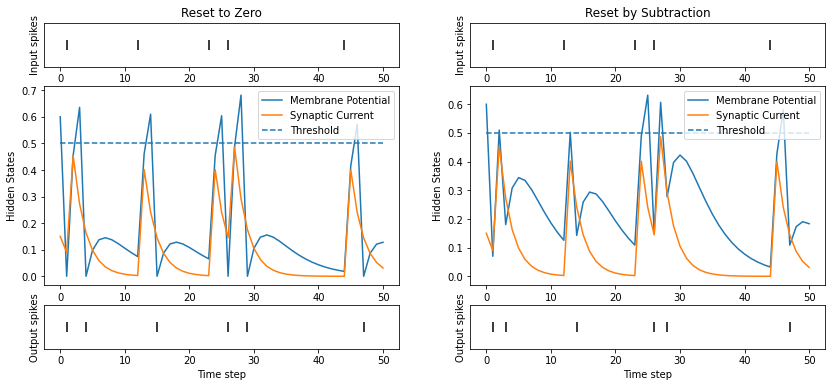

In [49]:
# Plot a comparison between the reset mechanisms 

fig = plt.figure(facecolor="w", figsize=(14, 6))
spec = gridspec.GridSpec(ncols=2, nrows=3,
                         height_ratios=[0.4, 1.8, 0.4])

# Plot input spikes
ax0 = fig.add_subplot(spec[0])
splt.raster(spk_in.reshape(num_steps, -1), ax0, s=100, c="black", marker="|")
plt.ylabel("Input spikes")
plt.yticks([]) 
plt.title("Reset to Zero")

ax1 = fig.add_subplot(spec[1])
splt.raster(spk_in.reshape(num_steps, -1), ax1, s=100, c="black", marker="|")
plt.ylabel("Input spikes")
plt.yticks([]) 
plt.title("Reset by Subtraction")

# Plot hidden states: reset to zero
ax2 = fig.add_subplot(spec[2], sharex = ax0)
plt.plot(mem_rec_zero, label="Membrane Potential")
plt.plot(syn_rec_zero, label="Synaptic Current")
plt.hlines(lif3.threshold, 0, num_steps, colors=None, linestyles='dashed', label='Threshold')  # Plots a threshold bar
plt.ylabel("Hidden States")
plt.legend()

# Plot hidden states: reset by subtraction
ax3 = fig.add_subplot(spec[3], sharex = ax1)
plt.plot(mem_rec, label="Membrane Potential")
plt.plot(syn_rec, label="Synaptic Current")
plt.hlines(lif2.threshold, 0, num_steps, colors=None, linestyles='dashed', label='Threshold')  # Plots a threshold bar
plt.ylabel("Hidden States")
plt.legend()

# Plot output spikes generated by neuron
ax4 = fig.add_subplot(spec[4], sharex = ax0)
splt.raster(torch.tensor(spk_rec_zero[0:50]).reshape(num_steps, -1), ax4, s=100, c="black", marker="|")
plt.yticks([]) 
plt.xlabel("Time step")
plt.ylabel("Output spikes")
plt.xticks()

ax5 = fig.add_subplot(spec[5], sharex = ax1)
splt.raster(torch.tensor(spk_rec[0:50]).reshape(num_steps, -1), ax5, s=100, c="black", marker="|")
plt.yticks([]) 
plt.xlabel("Time step")
plt.ylabel("Output spikes")
plt.xticks()

plt.show()

Pay close attention to the evolution of the membrane potential, especially in the moments after it reaches the threshold. Although quite similar, it is possible to see for "Reset to Zero", the membrane potential is forced back to zero after each spike.  

So which one is better? Applying `"subtract"` (the default value in `reset_mechanism`) loses less information, because `"zero"` will ignore how much the membrane exceeds the threshold by.

On the other hand, applying a hard reset with `"zero"` promotes sparsity and potentially less power consumption. Both options are available for you to experiment with. 

### 2.2 The Quantitative Approach

By now, should have a feel for what's going on with the leaky integrate and fire neuron:

1.   Input spikes are integrated by the synaptic current
2.   The synaptic current decays at a rate, $\alpha$
3.   The membrane potential integrates the synaptic current, and decays at a rate $\beta$
4.   If the membrane potential reaches its threshold, it will emit a spike and reset by subtraction (default).

Let's dig a bit deeper. Where do these dynamics come from? 

--> Neuronal Dynamics Circuit

--> Accompanying Mathematical Description

--> Mathematical description with reset function

--> Computational graph

Neural Network

--> Population of Stein neuron models

--> Combining it with nn.Linear

* First do a code demo. Watch the membrane rise with incoming spikes [create a spiketrain using spikegen?]

* Increasing the decay rate, change alpha/beta around

* Electrical model of Stein's model [use the previous latency diagram]

* computational graph of Stein's model interpretation

* SRM0 model

* First do a code demo and show the differences

* Convolution interpretation

* recurrent model

* reset by zero, reset by subtraction

* try concatenating many SRM0's together. bit painful. let's try hidden_init instead and show how that works. Call the instance variables etc. 

---



### 1.2 Define network and SNN parameters
We will use a 784-1000-10 FCN architecture for a sequence of 25 time steps.

* `alpha` is the decay rate of the synaptic current of a neuron
* `beta` is the decay rate of the membrane potential of a neuron

In [ ]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Training Parameters
batch_size=128
data_path='/data/mnist'

# Temporal Dynamics
num_steps = 25
time_step = 1e-3
tau_mem = 3e-3
tau_syn = 2.2e-3
alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### 1.3 Download MNIST Dataset
To see how to construct a validation set, refer to Tutorial 1.

In [ ]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

### 1.4 Create DataLoaders

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 2. Define Network
snnTorch treats neurons as activations with recurrent connections. This allows for smooth integration with PyTorch.
There are a few useful neuron models and surrogate gradient functions which approximate the gradient of spikes.

Our network will use one type of neuron model and one surrogate gradient:
1. `snntorch.Stein` is a basic leaky integrate and fire (LIF) neuron. Specifically, it assumes instantaneous rise times for synaptic current and membrane potential.
2. `snntorch.FastSigmoidSurrogate` defines separate forward and backward functions. The forward function is a Heaviside step function for spike generation. The backward function is the derivative of a fast sigmoid function, to ensure continuous differentiability.
The `FastSigmoidSurrogate` function has been adapted from:

>Neftci, E. O., Mostafa, H., and Zenke, F. (2019) Surrogate Gradient Learning in Spiking Neural Networks. https://arxiv.org/abs/1901/09948

In [ ]:
# from snntorch import surrogate
#
# spike_grad = surrogate.FastSigmoid.apply
# snn.slope = 50

The surrogate is passed to `spike_grad` and overrides the default gradient of the Heaviside step function.
If we did not override the default gradient, (zero everywhere, except for $x=1$ where it is technically infinite but clipped to 1 here), then learning would not take place for as long as the neuron was not emitting post-synaptic spikes.

`snn.slope` defines the slope of the backward surrogate.

TO-DO: Include visualisation.

Now we can define our spiking neural network (SNN).
Creating an instance of the `Stein` neuron requires two arguments and two optional arguments:
1. $I_{syn}$ decay rate, $\alpha$,
2. $V_{mem}$ decay rate, $\beta$,
3. the surrogate spiking function, `spike_grad` (*default*: the gradient of the Heaviside function), and
4. the threshold for spiking, (*default*: 1.0).

snnTorch treats the LIF neuron as a recurrent activation. Therefore, it requires initialization of its internal states.
For each layer, we initialize the synaptic current `syn1` and `syn2`, the membrane potential `mem1` and `mem2`, and the post-synaptic spikes `spk1` and `spk2` to zero.
A class method `init_stein` will take care of this.

For rate coding, the final layer of spikes and membrane potential are used to determine accuracy and loss, respectively.
So their historical values are recorded in `spk2_rec` and `mem2_rec`.

Keep in mind, the dataset we are using is just static MNIST. I.e., it is *not* time-varying.
Therefore, we pass the same MNIST sample to the input at each time step.
This is handled in the line `cur1 = self.fc1(x)`, where `x` is the same input over the whole for-loop.

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

    # initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = self.lif2.init_stein(batch_size, num_outputs)

        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)

## 3. Training
Time for training! Let's first define a couple of functions to print out test/train accuracy.

In [ ]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, train=True)
    print_batch_accuracy(testdata_it, testtargets_it, train=False)
    print("\n")

### 3.1 Optimizer & Loss
* *Output Activation*: We'll apply the softmax function to the membrane potentials of the output layer, rather than the spikes.
* *Loss*: This will then be used to calculate the negative log-likelihood loss.
By encouraging the membrane of the correct neuron class to reach the threshold, we expect that neuron will fire more frequently.
The loss could be applied to the spike count as well, but the membrane is  continuous whereas spike count is discrete.
* *Optimizer*: The Adam optimizer is used for weight updates.
* *Accuracy*: Accuracy is measured by counting the spikes of the output neurons. The neuron that fires the most frequently will be our predicted class.

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

### 3.2 Training Loop
Now just sit back, relax, and wait for convergence.

In [ ]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        output, mem_rec = net(data_it.view(batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps: BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)

        # Weight Update
        nn.utils.clip_grad_norm_(net.parameters(), 1) # gradient clipping
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set forward pass
        test_output, test_mem_rec = net(testdata_it.view(batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

## 4. Results
### 4.1 Plot Training/Test Loss

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 4.2 Test Set Accuracy
This function just iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [ ]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      outputs, _ = net(images.view(batch_size, -1))

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      outputs, _ = net(images.view(images.size()[0], -1))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

Voila! That's it for static MNIST.

## 5. Spiking MNIST
Part of the appeal of SNNs is their ability to handle time-varying spiking data. So let's use rate-coding to convert MNIST into spiking MNIST using the `spikegen` module in the previous tutorial, and train our network with that instead.

In [ ]:
from snntorch import spikegen

# MNIST to spiking-MNIST
spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps, gain=1,
                                          offset=0, convert_targets=False, temporal_targets=False)

### 5.1 Visualiser
Just so you're damn sure it's a spiking input.

In [ ]:
!pip install celluloid # matplotlib animations made easy

In [ ]:
from celluloid import Camera
from IPython.display import HTML

# Animator
spike_data_sample = spike_data[:, 0, 0].cpu()

fig, ax = plt.subplots()
camera = Camera(fig)
plt.axis('off')

for step in range(num_steps):
    im = ax.imshow(spike_data_sample[step, :, :], cmap='plasma')
    camera.snap()

# interval=40 specifies 40ms delay between frames
a = camera.animate(interval=40)
HTML(a.to_html5_video())

In [ ]:
print(spike_targets[0])

## 6. Define Network
The network is the same as before. The one difference is that the for-loop iterates through the first dimension of the input:
`cur1 = self.fc1(x[step])`

In [ ]:
spike_grad = snn.FastSigmoidSurrogate.apply
snn.slope = 50 # The lower the slope, the smoother the gradient

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        # Initialize hidden states + output spike at t=0
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = self.lif2.init_stein(batch_size, num_outputs)

        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)

## 7. Training
We make a slight modification to our print-out functions to handle the new first dimension of the input:

In [ ]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(num_steps, batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(spike_data, spike_targets, train=True)
    print_batch_accuracy(test_spike_data, test_spike_targets, train=False)
    print("\n")


### 7.1 Optimizer & Loss
We'll keep our optimizer and loss the exact same as the static MNIST case.

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

### 7.2 Training Loop
The training loop is identical to the static MNIST case, but we pass each minibatch through `spikegen.rate` before running it through the feedforward network.

In [ ]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    data = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator
        spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps,
                                                  gain=1, offset=0, convert_targets=False, temporal_targets=False)

        # Forward pass
        output, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(net.parameters(), 1)

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data, test_spike_targets = spikegen.rate(testdata_it, testtargets_it, num_outputs=num_outputs,
                                                            num_steps=num_steps, gain=1, offset=0, convert_targets=False, temporal_targets=False)

        # Test set forward pass
        test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, test_spike_targets)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

## 8. Spiking MNIST Results
### 8.1 Plot Training/Test Loss

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 8.2 Test Set Accuracy

In [ ]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                            gain=1, offset=0, convert_targets=False, temporal_targets=False)

      outputs, _ = net(spike_test.view(num_steps, batch_size, -1))

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                gain=1, offset=0, convert_targets=False, temporal_targets=False)

      outputs, _ = net(spike_test.view(num_steps, images.size()[0], -1))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += spike_targets.size(0)
    correct += (predicted == spike_targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

That's all for now!
Next time, we'll introduce how to use spiking convolutional layers to improve accuracy.